# Assignment 07: Due Monday 10/16

In this assignment we will look at some siumulated $\pi^-$ data from the electron-ion collider (EIC) experiment ePIC. We will use a subset of the ePIC simulation data to assess the tracking performance, specifically the momentum resolutions, of the ePIC tracking system. 

For curious readers interested in seeing the code framework of a developing experiment (not needed for the assignemt)

* ePIC geometry/GEANT simulation code: https://github.com/eic/epic

* ePIC reconstruction code: https://github.com/eic/EICrecon


## Imports 

For this assignemnt you will need the following imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
from scipy.optimize import curve_fit #simpliest scipy fitting method
%matplotlib notebook

import scipy.special as sf
import seaborn as sns

# Problem 1A)

Create a Pandas DataFrame object from the data file *epic_3511.csv*, located in the *data* dircetroy, and use the *info* function to list the information from the DataFrame.

In [2]:
epic_data = pd.read_csv('data/epic_3511.csv')

# Problem 1B)

Now explore the data a little bit. 
1. Are there any NAN or NULL values to worry about?
2. Use the DataFrame *hist()* method to histogram the DataFrame quantities.
3. Use DataFrame *cor()* method to investigate if any quantites are correlated? What quantity pairs show a strong correlation?

0


<IPython.core.display.Javascript object>


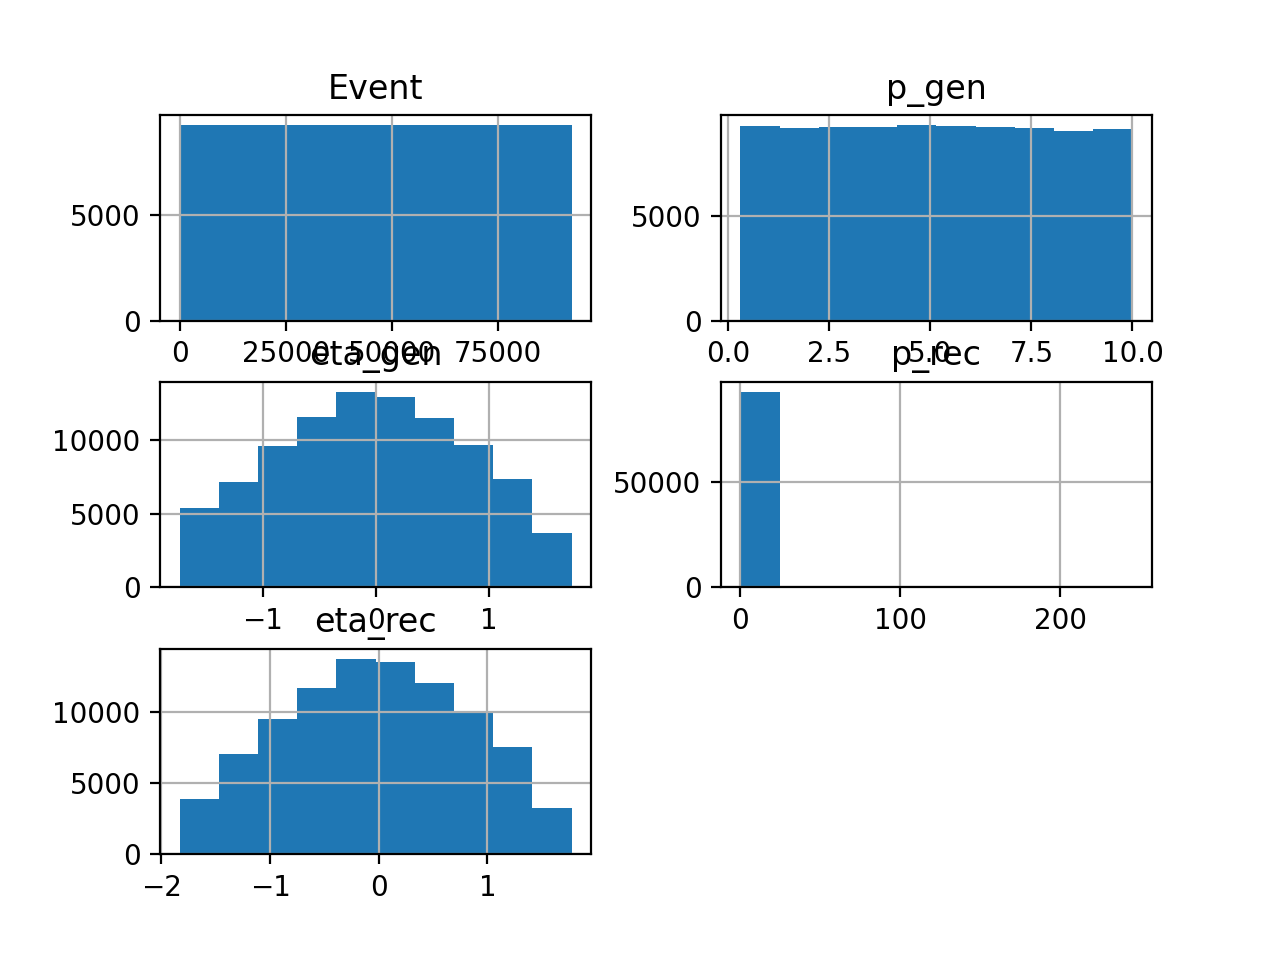

,Event,p_gen,eta_gen,p_rec,eta_rec
Event,1.000000,-0.003699,-0.000766,-0.001957,-0.000764
p_gen,-0.003699,1.000000,0.005566,0.929444,0.005553
eta_gen,-0.000766,0.005566,1.000000,0.006302,0.999996
p_rec,-0.001957,0.929444,0.006302,1.000000,0.006292
eta_rec,-0.000764,0.005553,0.999996,0.006292,1.000000


In [3]:
null_data = epic_data.isnull().sum() #dataframe copy with values that are null/NaN
print(null_data.isnull().sum())
epic_data.hist()
epic_data.corr()

The quantity pairs that have a strong correlation are that of p_gen to p_rec, and eta_gen to eta_rec.

# Problem 1C)
Visualize the correlation by generating a heatmap of the correlation table. To do this we will use the Seaborn heatmap method *heatmap*

Your heatmap should look something like: 
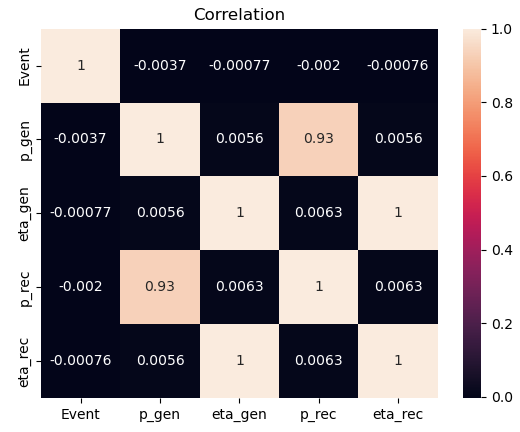

<IPython.core.display.Javascript object>


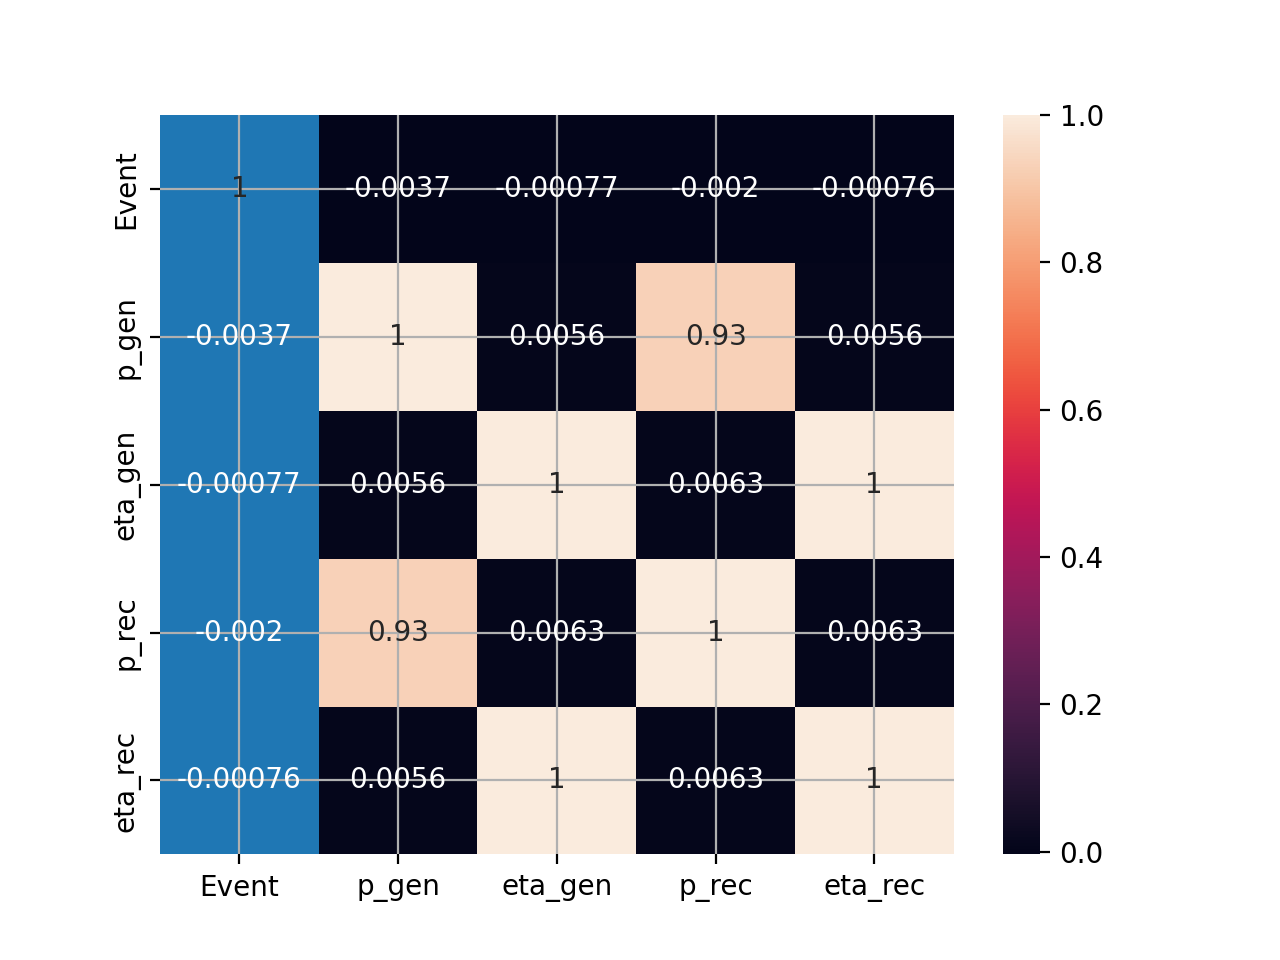

<Axes: >

In [4]:
fig = plt.figure()
sns.heatmap(epic_data.corr(), annot=True) #plot heatmap of epic_data correlation.

# Problem 2A)

In this assignment we will assess the tracking performance by calculating the momentum resolution. 
Define a new series in the DataFrame that calculates the momentum resolution and name it *p\_diff*, which should be defiend as
$$ \mathrm{p\_diff} = 100*(\mathrm{p\_rec} - \mathrm{p\_gen})/\mathrm{p\_gen} $$ 

This will give the difference between the reconstructed and generated momentum in percent.

Verify that this quantity is now defined and populated in your DataFrame.

In [5]:
epic_data["p_diff"] = (100*(epic_data.p_rec - epic_data.p_gen)/epic_data.p_gen) #creates new column for p_diff
epic_data #includes new dataframe entry for p_diff

,Event,p_gen,eta_gen,p_rec,eta_rec,p_diff
0,0,1.3154,0.3127,1.3160,0.3127,0.045614
1,1,6.3253,-0.6326,6.3514,-0.6327,0.412629
2,2,5.0703,0.1224,5.0936,0.1224,0.459539
3,3,1.5437,0.7066,1.5433,0.7064,-0.025912
4,4,2.3808,-0.4544,2.3632,-0.4542,-0.739247
...,...,...,...,...,...,...
92288,92288,6.4992,0.0144,6.4060,0.0144,-1.434023
92289,92289,8.8592,-0.6944,8.8872,-0.6942,0.316056
92290,92290,3.5989,0.5254,3.5642,0.5255,-0.964184
92291,92291,3.9749,-1.3634,3.9016,-1.3628,-1.844072


# Problem 2B)
1. Generate a histogram of the momentum difference. When creating the histogram use 100 bins and histogram range from -1% to +1%. Hint: Look at the matplotlib *hist()* method reference to see how to specify a histogram bin range.

2. Create x, y, and y_error arrays, where x contains the bin centers of the histogram bins, y is the counts in each bin, and y_error is the square root of the counts in each bin (e.g. $\sqrt{y}$). These will be used later for fitting purposes. 

<IPython.core.display.Javascript object>


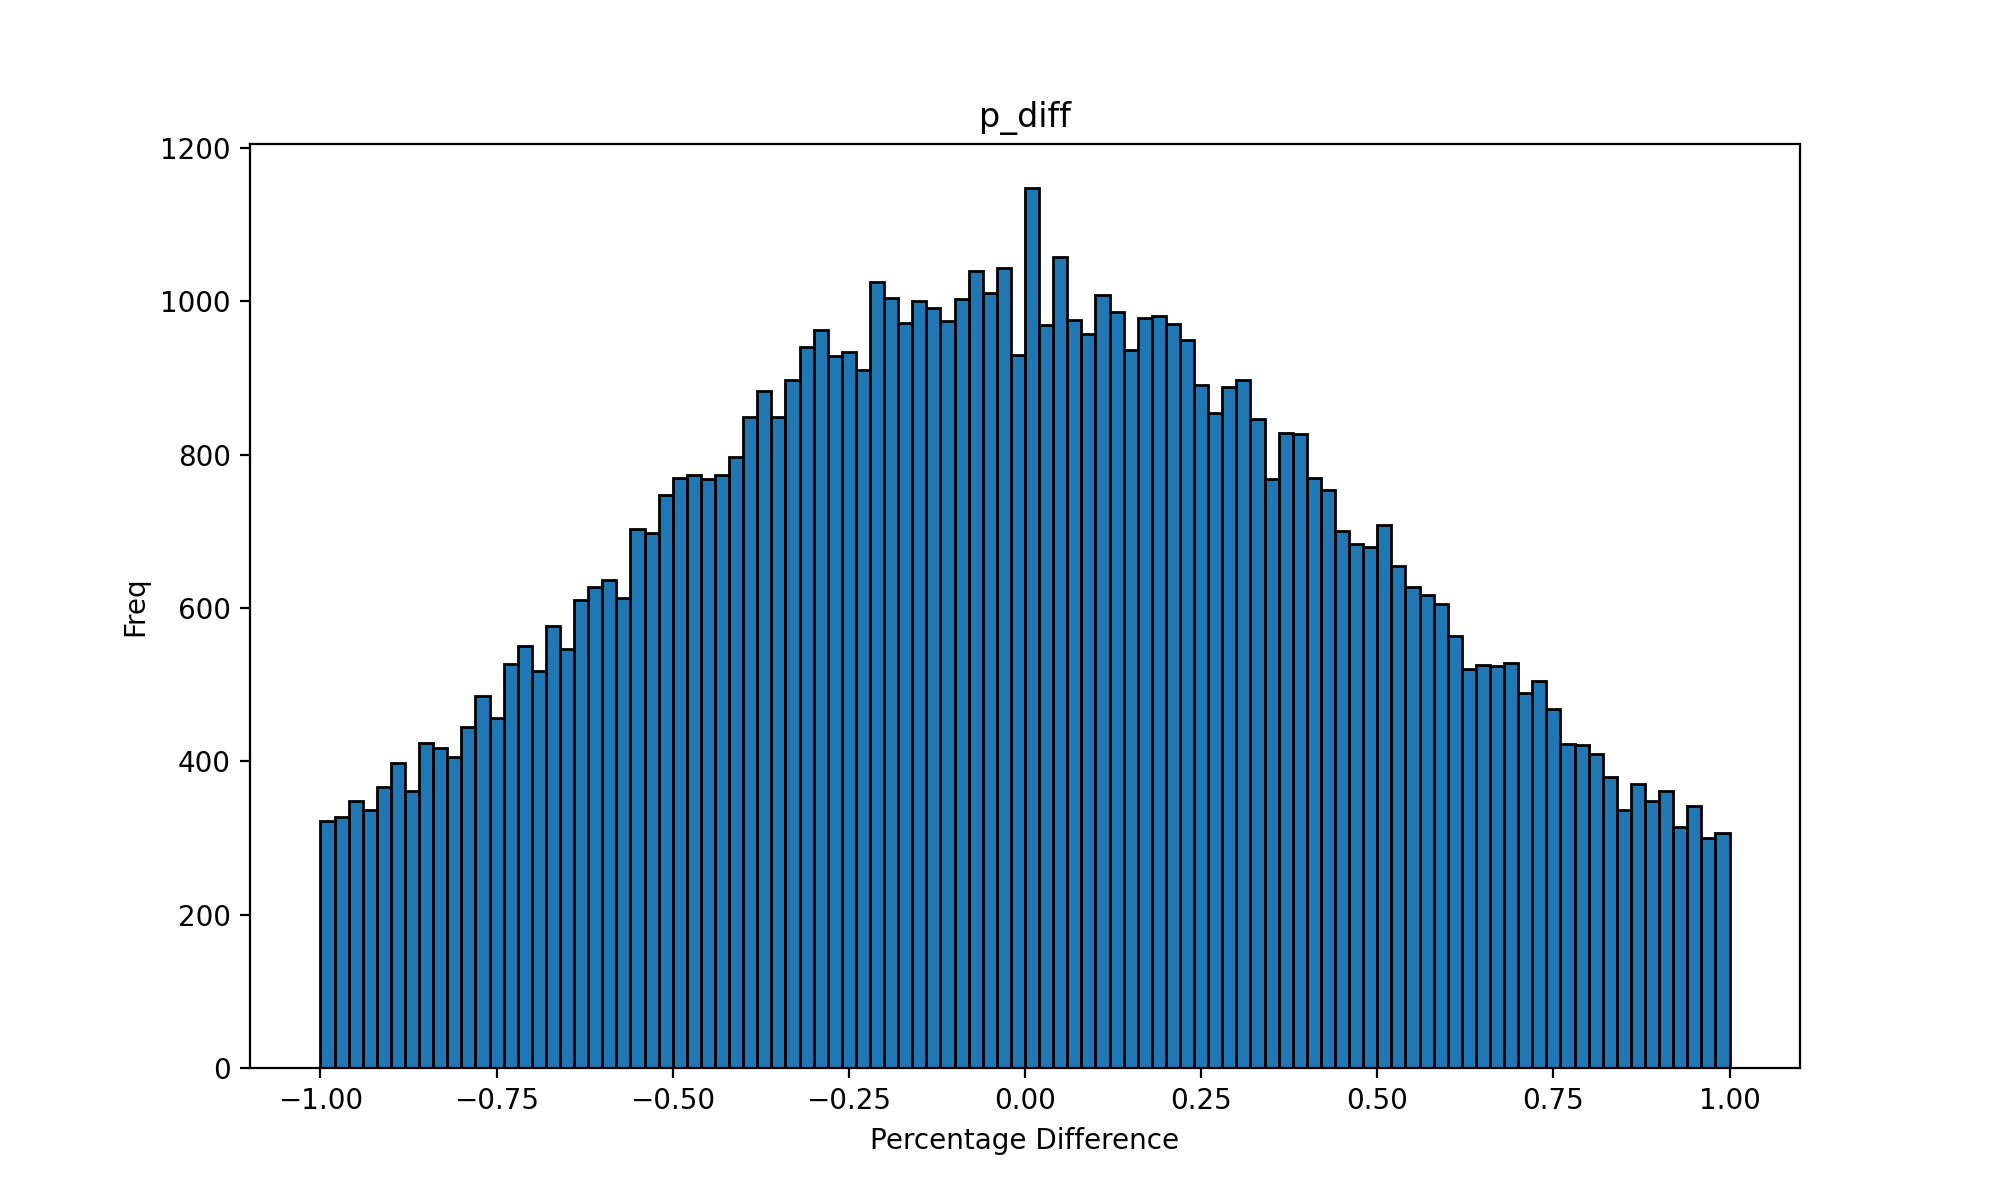

In [6]:
range_data = (-1, 1)

epic_data['p_diff'].hist(range = range_data)

plt.figure(figsize=(10, 6))
plt.hist(epic_data['p_diff'], bins=100, range=range_data, edgecolor='black')

plt.xlabel('Percentage Difference')
plt.ylabel('Freq')
plt.title('p_diff')

plt.show()


In [7]:
histogram, bin_edges = np.histogram(epic_data.p_diff, bins=100, range=range_data) #Create numpy histogram to get the bin edges

x = ((bin_edges[1:] + bin_edges[:-1]) / 2) #x = bin centers
y = histogram #y = counts in each bin
y_error = np.sqrt(histogram)

# Problem 3A)

The momentum distribution appears to follow a Gaussian distribution, and so the momnetum resolution provided by the tracking system can be calculated from the width of the distribution. We will fit the momentum distribution with a Gaussian function and extract the value of the Gaussian $\sigma$, which is the momentum resolutuon of the tracking system.

1. Define a function that returns a value computed from a Gaussian distribution. The Gaussian function should have the form:
$$ G(x) =  p_1 e^{-(x-p_2)^2/(2p_3)}$$,

where $x$ will be the momentum difference, $p_1,p_2,$ and $p_3$ are parameters determining the specific form of the Gaussian curve which will be optimized during fitting of the momentum difference distribution.

Your function should take x, p_1, p_2, and p_3 as arguments and return the output of $G(x)$.

In [8]:
def gaussian(x_data, p1, mean, std_dev): #gaussian model function to be used for curve_fit
    
    return p1 * np.exp(-(x_data - mean)**2 / (2 * std_dev))

# Problem 3B)

Starting with the inital paramters $$p1=500, p2=0, p3=1$$ ,fit the momentum difference distribution using *curve_fit* from the Scipy library.

**Q: What is the momentum resolution?** 

In [9]:
initial_parameters = (500, 0, 1)

popt, pcov = curve_fit(gaussian, x, y, p0=initial_parameters, sigma=y_error)


# Problem 3C)
1. Draw a histogram of the distribution with the fit result drawn on as well.
2. Calculate the reduced $\chi^2$ of the fit.
3. Calculate the p-value of the fit.
**Q: Does the fit do a good job describing the data within the $\pm1\%$ range? Explain**
Fitted histogram over $\pm1 \%$ range should look like this:
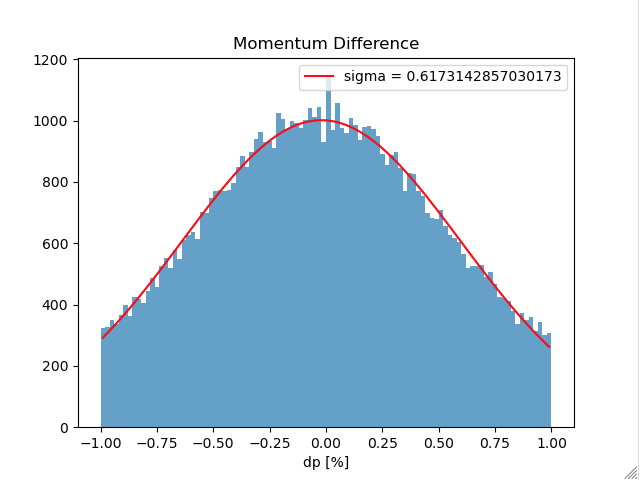

**Q: What happens to how the fit describes the data if we open up the range to cover from -5% to 5%, is it worst or better? What does this say about our assumption that the distribution is purely Gaussian?**

The fit after expanding the range is significantly worse suggesting the fit is not purely gaussian.

<IPython.core.display.Javascript object>


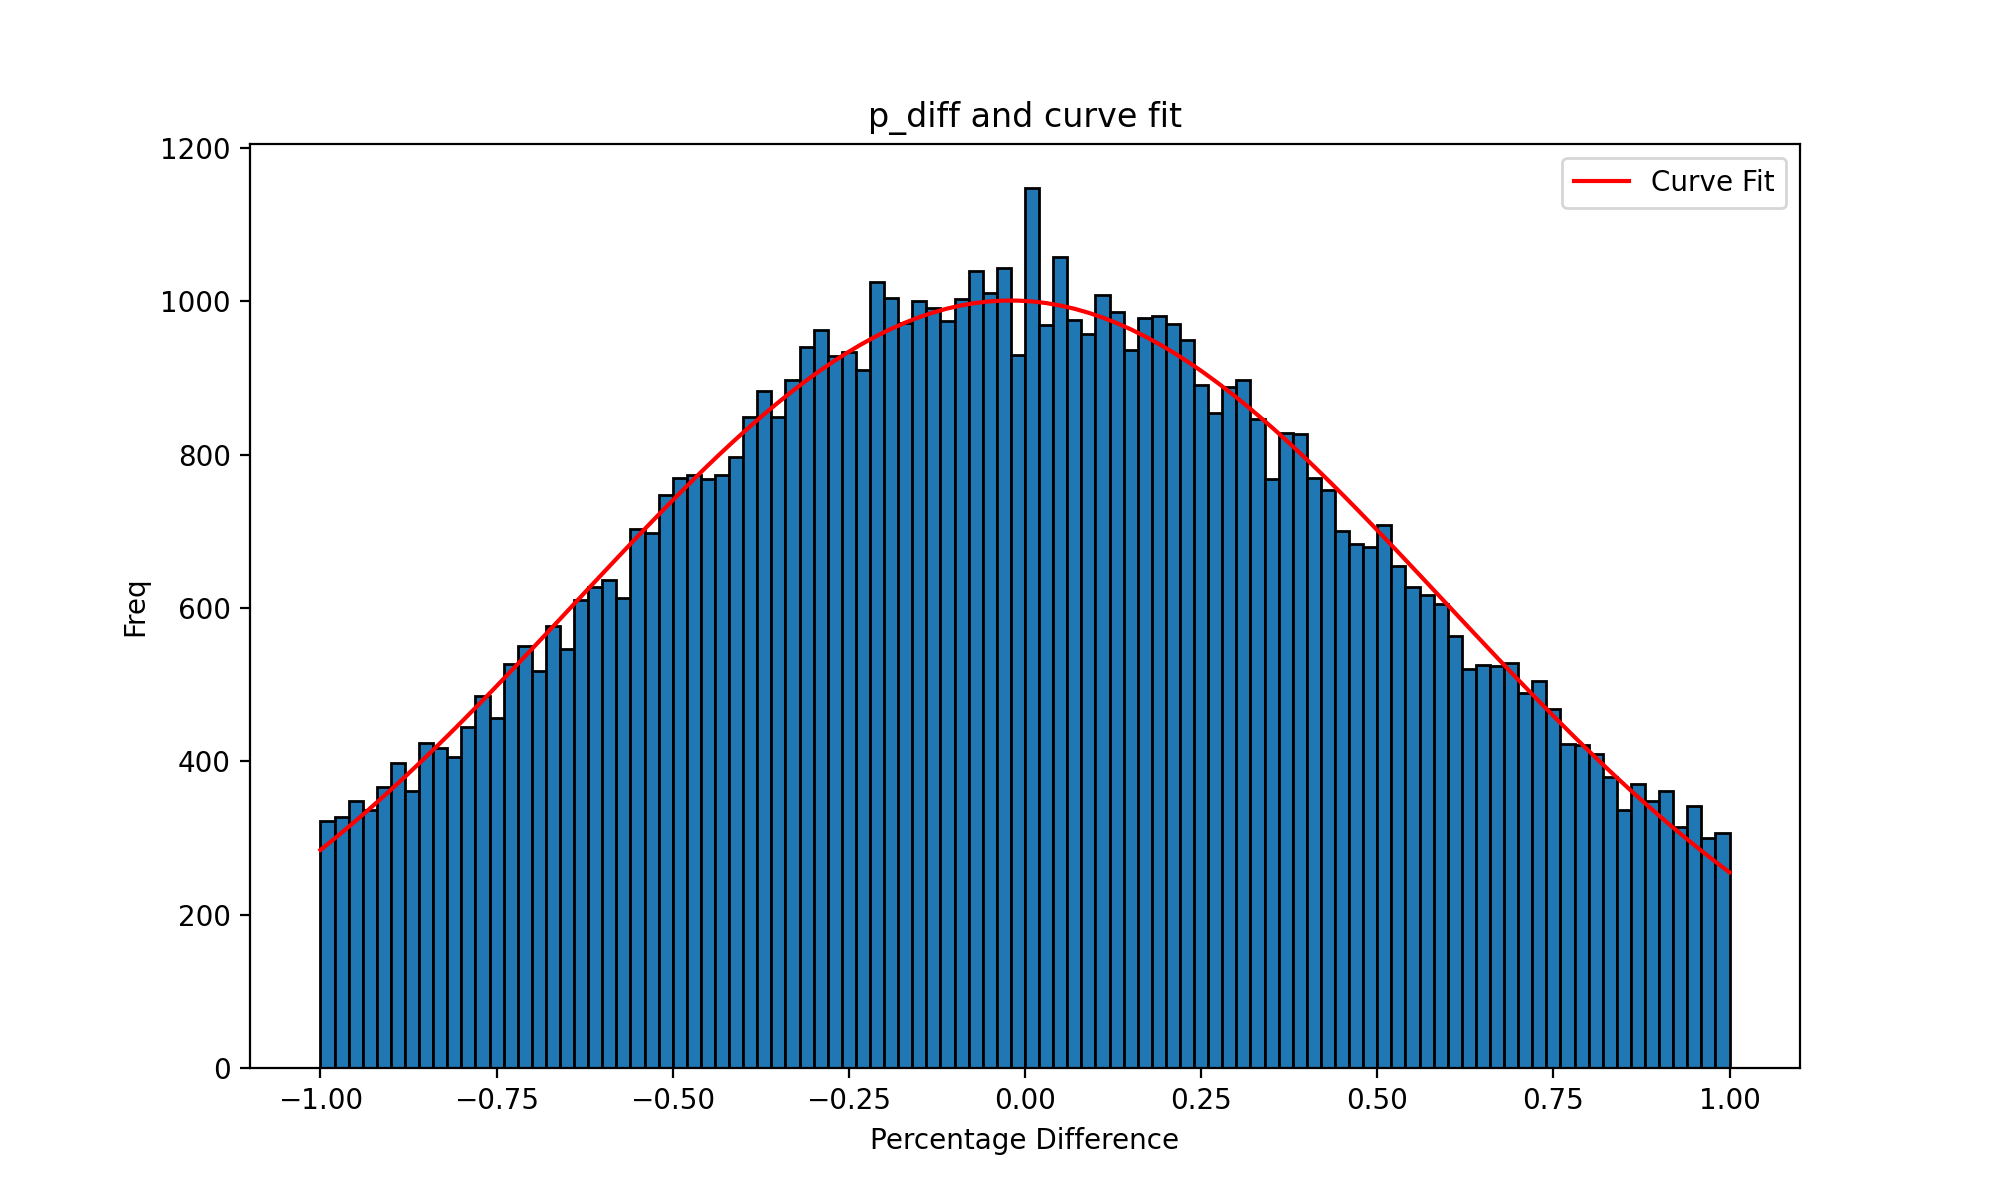

Reduced Chi-squared: 1.602596075399834


In [10]:
#-1% to 1%
x_fit = np.linspace(-1, 1, 100) #x values for 
y_fit = gaussian(x_fit, *popt) #y values for curve fit 2

plt.figure(figsize=(10, 6))
plt.hist(epic_data['p_diff'], bins=100, range=range_data, edgecolor='black')
plt.plot(x_fit, y_fit, 'r-', label='Curve Fit') 
plt.xlabel('Percentage Difference')
plt.ylabel('Freq')
plt.title('p_diff and curve fit')

plt.legend();
plt.show()

#fit calculations
chi_squared = np.sum(((y - y_fit) ** 2) / (y_error ** 2))
N = len(y)
parameters = 3 
reduced_chi_squared = chi_squared/(N - parameters)

print("Reduced Chi-squared:", reduced_chi_squared)


<IPython.core.display.Javascript object>


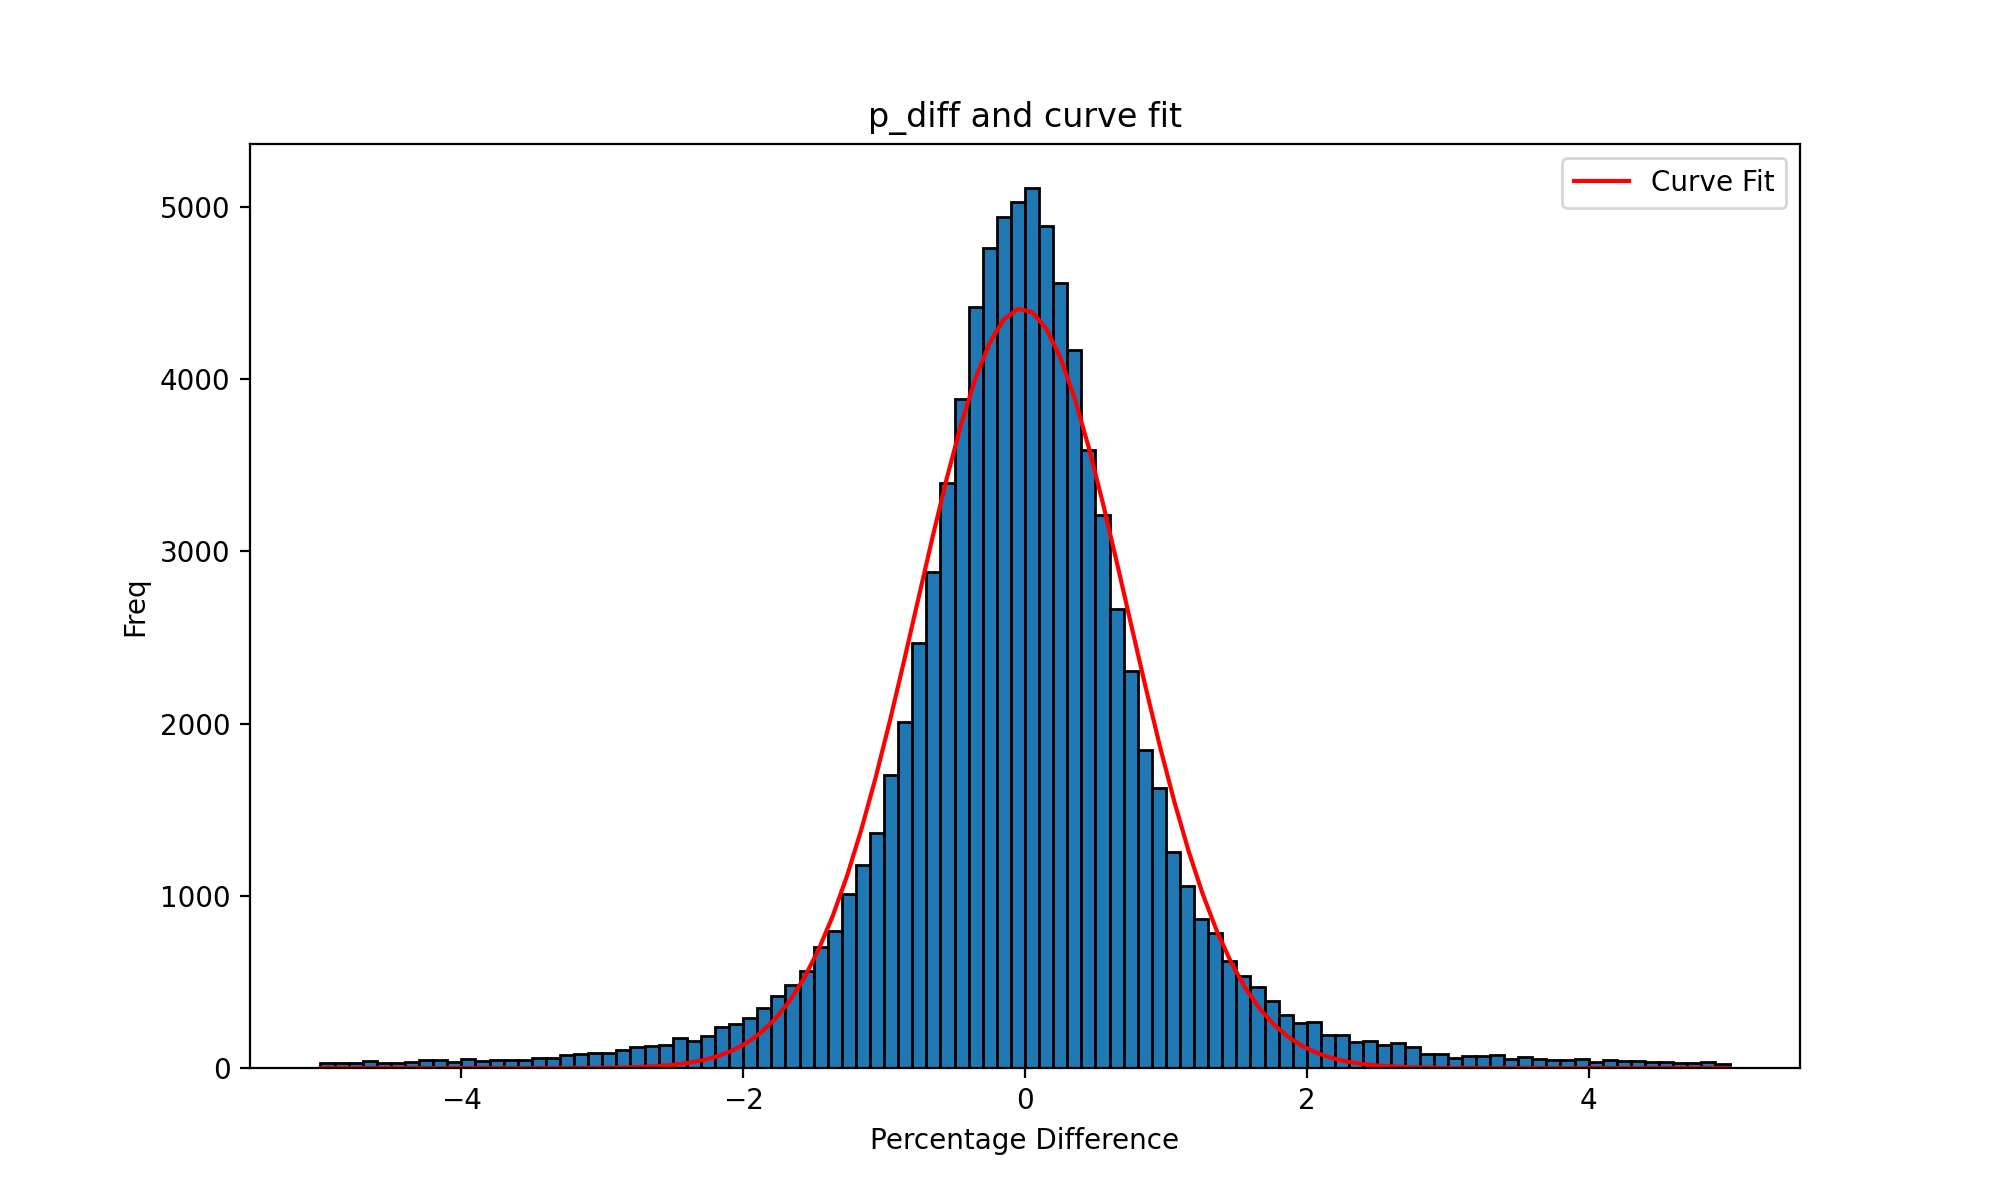

Reduced Chi-squared: 56.549092542485035


In [11]:
#-5% to 5%
range_data2 = (-5, 5)

histogram2, bin_edges2 = np.histogram(epic_data.p_diff, bins=100, range=range_data2) #Create numpy histogram to get the bin edges

x2 = ((bin_edges2[1:] + bin_edges2[:-1]) / 2) #x = bin centers
y2 = histogram2 #y = counts in each bin
y_error2 = np.sqrt(histogram2)

popt2, pcov2 = curve_fit(gaussian, x2, y2, p0=initial_parameters, sigma=y_error2)

x_fit2 = np.linspace(-5, 5, 100) #x values for 
y_fit2 = gaussian(x_fit2, *popt2) #y values for curve fit

plt.figure(figsize=(10, 6))
plt.hist(epic_data['p_diff'], bins=100, range=range_data2, edgecolor='black')
plt.plot(x_fit2, y_fit2, 'r-', label='Curve Fit') 
plt.xlabel('Percentage Difference')
plt.ylabel('Freq')
plt.title('p_diff and curve fit')

plt.legend();
plt.show()

#fit calculations
chi_squared2 = np.sum(((y2 - y_fit2) ** 2) / (y_error2 ** 2))
N2 = len(y2)
parameters = 3 
reduced_chi_squared2 = chi_squared2/(N2 - parameters)

print("Reduced Chi-squared:", reduced_chi_squared2)


# Problem 4A)

In Problem 3 we computed the momentum resolution by integrating over the entire momentum and $\eta$ range. However, the tracking performance could change as function of both momentum and $\eta$. 

To access how the momentum resolution changes as a function of $\eta$, we will split our *p_diff* values into three $\eta$ regions:
* Backward: $\eta < -1$
* Central: $|\eta| < 1$
* Forward: $\eta > 1$

Create three new DataFrames that contain the momentum difference values for the specified $\eta$ ranges and then create histograms showing the momentum difference in each of these $\eta$ regions. When working with the $\eta$ values, use eta_gen values.

<IPython.core.display.Javascript object>


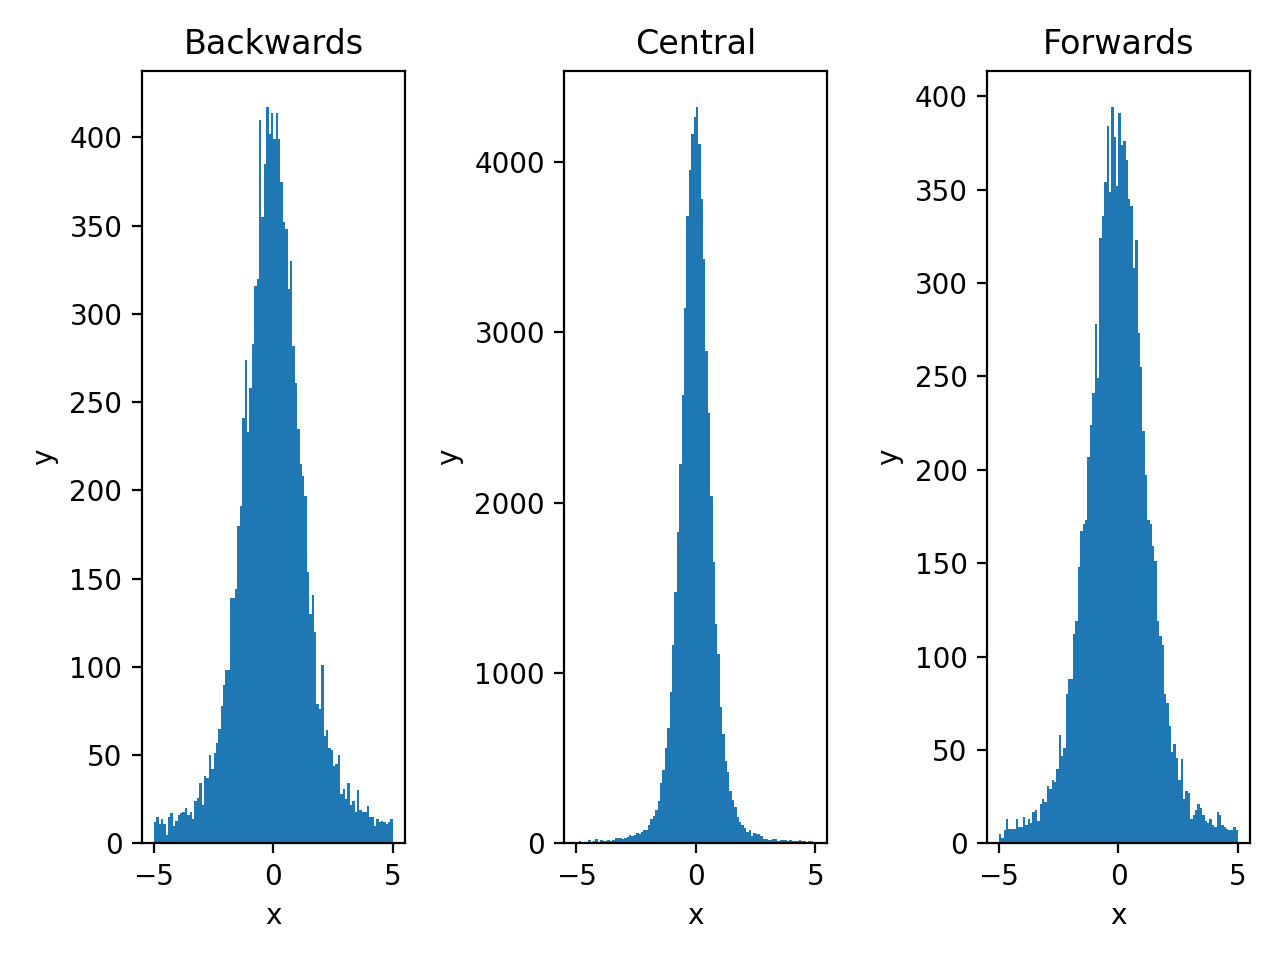

In [12]:
backward = epic_data[epic_data['eta_gen'] < -1]
central = epic_data[abs(epic_data['eta_gen']) < 1]
forward = epic_data[epic_data['eta_gen'] > 1]

fig, axes = plt.subplots(1,3)

axes[0].hist(backward.p_diff, bins=100, range=range_data2)
axes[1].hist(central.p_diff, bins=100, range=range_data2)
axes[2].hist(forward.p_diff, bins=100, range=range_data2)
axes[0].set_title('Backwards')
axes[0].set_xlabel('x')
axes[0].set_ylabel('y')
axes[1].set_title('Central')
axes[1].set_xlabel('x')
axes[1].set_ylabel('y')
axes[2].set_title('Forwards')
axes[2].set_xlabel('x')
axes[2].set_ylabel('y')
plt.tight_layout();

plt.show()

# Problem 4B)

Fit each of the 3 $\eta$ regions with a Gaussian function to get a more quantatative idea of how the resolution changes as a function of $\eta$. For this fit you can use the range -5% to 5% and **do not** need to calculate $\chi^2$ or a p-value for this problem.

Your 3 fitted histograms shoul look like this:
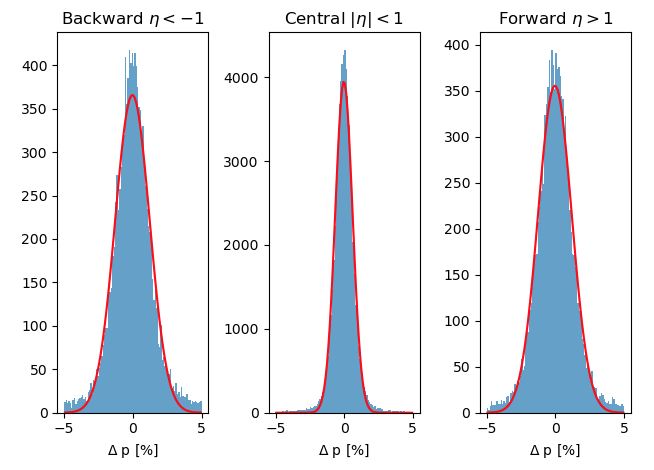

**Q: What region provides the best momentum resolution?** 

**Q: What region provides the worst momentum resolution?** 

The region with the best resolution appears to be the Central region.
The region with the worst resolution appears to be the Backwards region.

<IPython.core.display.Javascript object>


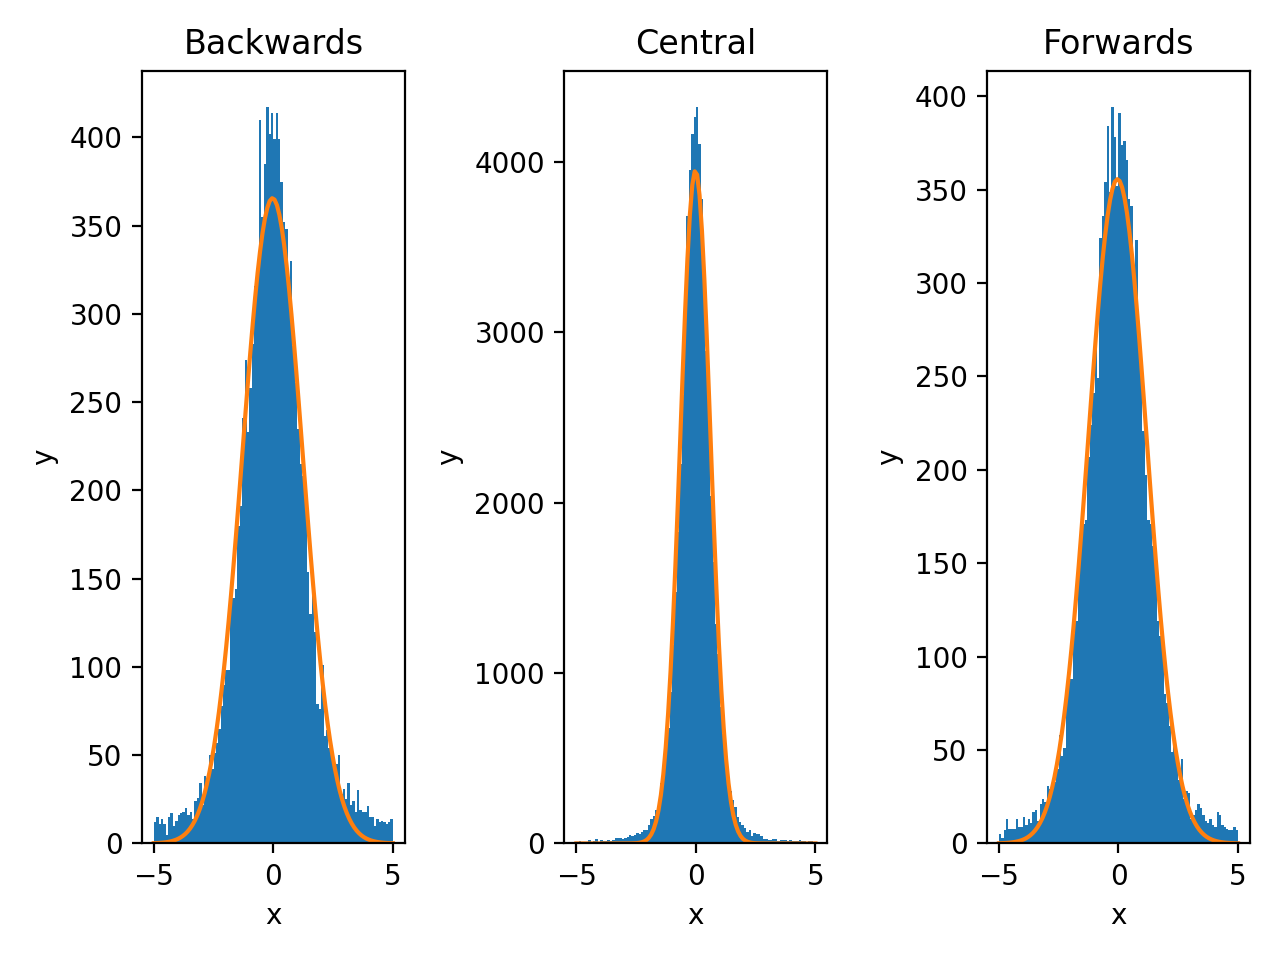

In [45]:

def fit_calculator(dataframe): #function to find the fit parameters with a passed dataframe
    
    histogram_func, bin_edges_func = np.histogram(dataframe, bins=100, range=range_data2)

    x_func = ((bin_edges_func[1:] + bin_edges_func[:-1]) / 2) #x = bin centers
    y_func = histogram_func #y = counts in each bin
    y_error_func = np.sqrt(histogram_func)
    y_error_func[y_error_func == 0] = 1e-6 #incase attempt to divide by zero

    popt_func, pcov_func = curve_fit(gaussian, x_func, y_func, p0=initial_parameters, sigma=y_error_func)

    x_fit2 = np.linspace(-5, 5, 100) #x values for 
    y_fit_func = gaussian(x_fit2, *popt_func) #y values for curve fit
    
    return y_fit_func
    

#graphing
fig, axes = plt.subplots(1,3)

axes[0].hist(backward.p_diff, bins=100, range=range_data2)
axes[1].hist(central.p_diff, bins=100, range=range_data2)
axes[2].hist(forward.p_diff, bins=100, range=range_data2)
axes[0].set_title('Backwards')
axes[0].set_xlabel('x')
axes[0].set_ylabel('y')
axes[1].set_title('Central')
axes[1].set_xlabel('x')
axes[1].set_ylabel('y')
axes[2].set_title('Forwards')
axes[2].set_xlabel('x')
axes[2].set_ylabel('y')
axes[0].plot(x_fit2, fit_calculator(backward.p_diff));
axes[1].plot(x_fit2, fit_calculator(central.p_diff));
axes[2].plot(x_fit2, fit_calculator(forward.p_diff));
plt.tight_layout();

plt.show()

# Problem 5A)

In Problem 4 we investigated how the momentum resolution changes as a function of $\eta$. The momentum resolution is also dependent on the momentum of the particle being detectoed. In this problem we will look at the momentum dependence of the momentum resolution.

To access how the momentum resolution changes as a function of *p_gen*, we will split our *p_diff* values into three 5 momentum regions: (0,2), (2,4), (4,6), (6,8), (8,10)

Create five new DataFrames that contain the momentum difference values for the specified *p_gen* ranges and then create histograms showing the momentum difference in each of these p_gen regions. 

<IPython.core.display.Javascript object>


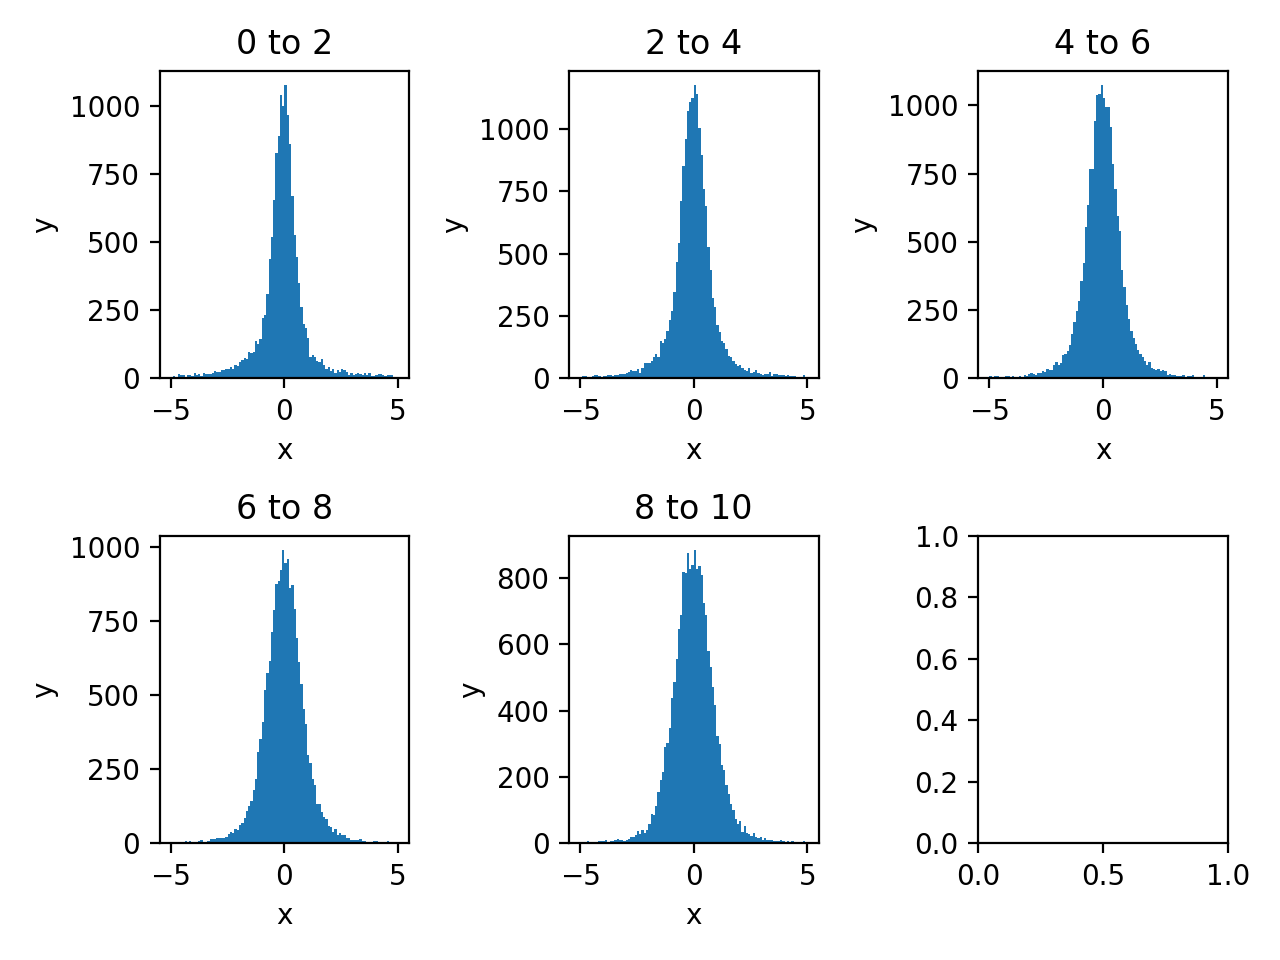

In [21]:
momentum_ranges = [(0, 2), (2, 4), (4, 6), (6, 8), (8, 10)]



def p_gen_calculator(min_region, max_region):  
    total_region=(min_region, max_region)
    p_gen_filtered = epic_data[(epic_data['p_gen'] >= min_region) & (epic_data['p_gen'] < max_region)]
    return p_gen_filtered

region_02 = p_gen_calculator(0,2)
region_24 = p_gen_calculator(2,4)
region_46 = p_gen_calculator(4,6)
region_68 = p_gen_calculator(6,8)
region_810 = p_gen_calculator(8,10)

#graphing
fig, axes = plt.subplots(2,3)

axes[0,0].hist(region_02.p_diff, bins=100, range=range_data2)
axes[0,1].hist(region_24.p_diff, bins=100, range=range_data2)
axes[0,2].hist(region_46.p_diff, bins=100, range=range_data2)
axes[1,0].hist(region_68.p_diff, bins=100, range=range_data2)
axes[1,1].hist(region_810.p_diff, bins=100, range=range_data2)
axes[0,0].set_title('0 to 2')
axes[0,0].set_xlabel('x')
axes[0,0].set_ylabel('y')
axes[0,1].set_title('2 to 4')
axes[0,1].set_xlabel('x')
axes[0,1].set_ylabel('y')
axes[0,2].set_title('4 to 6')
axes[0,2].set_xlabel('x')
axes[0,2].set_ylabel('y')
axes[1,0].set_title('6 to 8')
axes[1,0].set_xlabel('x')
axes[1,0].set_ylabel('y')
axes[1,1].set_title('8 to 10')
axes[1,1].set_xlabel('x')
axes[1,1].set_ylabel('y')
plt.tight_layout();

plt.show()


# Problem 5B)

Fit each of the 5 momentum regions with a Gaussian function to get a more quantatative idea of how the resolution changes as a function of p_gen. For this fit you can use the range -5% to 5% and **do not** need to calculate $\chi^2$ or a p-value for this problem.

Your 5 fitted histograms should look like this:
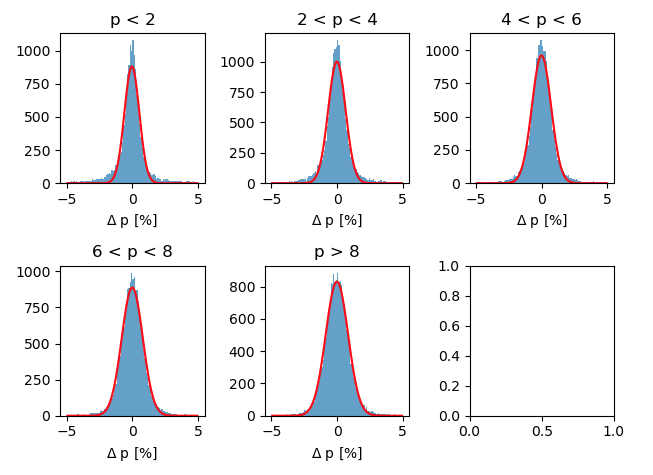

**Q: What region provides the best momentum resolution?**

**Q: What region provides the worst momentum resolution?**


The region with the best resolution appears to be the region >8.
The region with the worst resolution appears to be the region between 2 to 4.

<IPython.core.display.Javascript object>


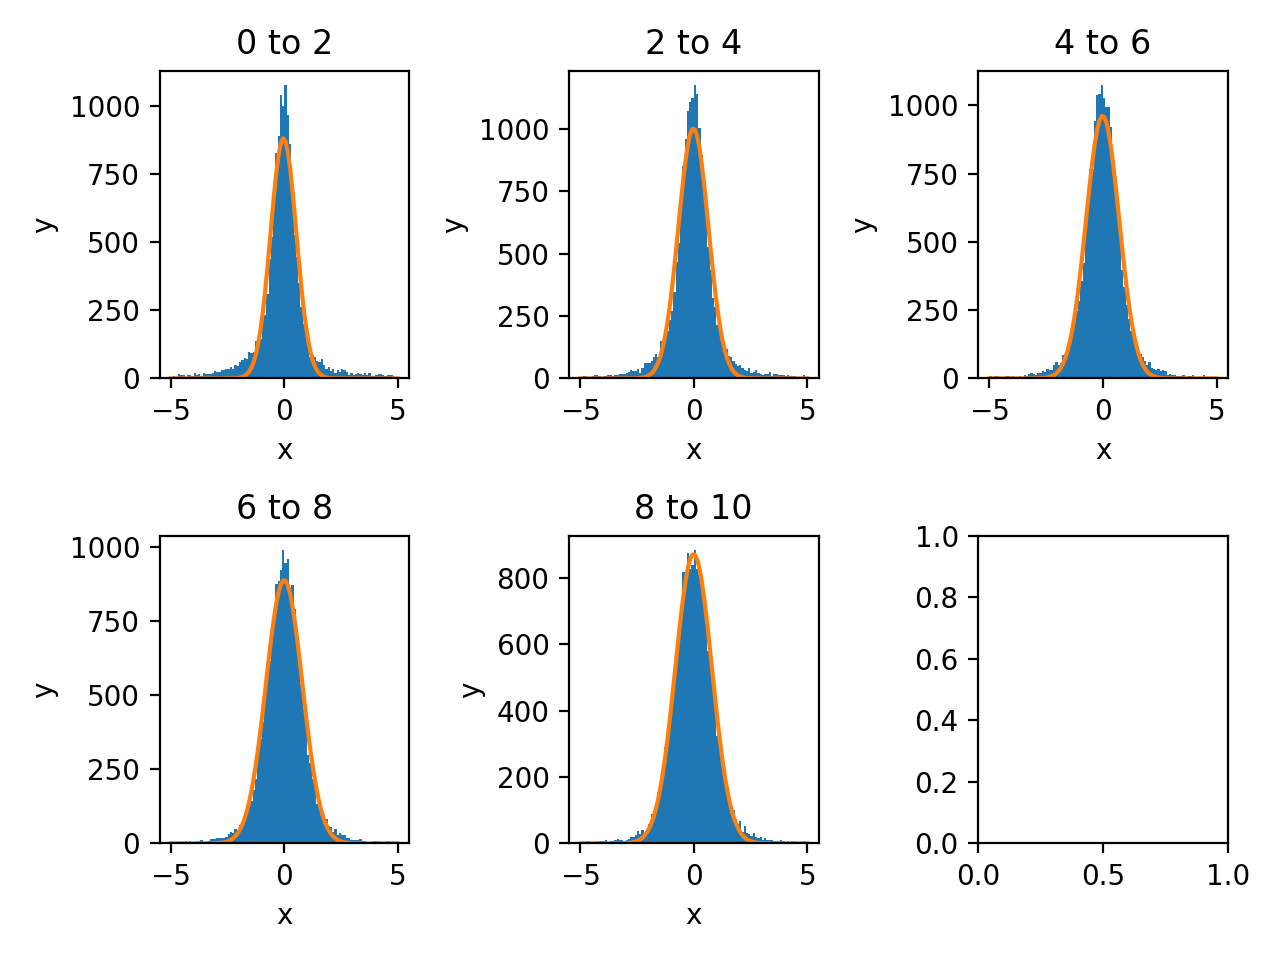

In [46]:
#graphing
fig, axes = plt.subplots(2,3)

axes[0,0].hist(region_02.p_diff, bins=100, range=range_data2)
axes[0,1].hist(region_24.p_diff, bins=100, range=range_data2)
axes[0,2].hist(region_46.p_diff, bins=100, range=range_data2)
axes[1,0].hist(region_68.p_diff, bins=100, range=range_data2)
axes[1,1].hist(region_810.p_diff, bins=100, range=range_data2)
axes[0,0].set_title('0 to 2')
axes[0,0].set_xlabel('x')
axes[0,0].set_ylabel('y')
axes[0,1].set_title('2 to 4')
axes[0,1].set_xlabel('x')
axes[0,1].set_ylabel('y')
axes[0,2].set_title('4 to 6')
axes[0,2].set_xlabel('x')
axes[0,2].set_ylabel('y')
axes[1,0].set_title('6 to 8')
axes[1,0].set_xlabel('x')
axes[1,0].set_ylabel('y')
axes[1,1].set_title('8 to 10')
axes[1,1].set_xlabel('x')
axes[1,1].set_ylabel('y')
axes[0,0].plot(x_fit2, fit_calculator(region_02.p_diff));
axes[0,1].plot(x_fit2, fit_calculator(region_24.p_diff));
axes[0,2].plot(x_fit2, fit_calculator(region_46.p_diff));
axes[1,0].plot(x_fit2, fit_calculator(region_68.p_diff));
axes[1,1].plot(x_fit2, fit_calculator(region_810.p_diff));
plt.tight_layout();

plt.show()